Scientific programming in Python (Winter 2025/26)

# Sheet 05: Pandas

## Introduction

Solve this sheet in your group. Once done, upload your solution to your group's folder (under [`Groups`](https://studip.uni-osnabrueck.de/dispatch.php/course/files/index/6e9e531b6e84cadd07ac27fd03fb8493?cid=64105ba596df4fcc36ec266431aac621)).  Please do so before **December 9th, 2025**.  You should be able to explain your solution to your tutor in the feedback meeting.  You should solve at least 50% of the exercises on (N-1) of the  sheets, to participate in the project work of this course, which will start after the new year break.


**Note:** Due to high attendance, we are splitting the tutor sessions. Each exercise group (currently 6 participants) must divide into two subgroups of 3. Subgroup A attends Week 1, Subgroup B attends Week 2, then A attends Week 3, B attends Week 4, and so on. Please coordinate within your group to decide who attends each week and ensure that no more than three participants attend any session.
Exercise sheets will be handed out every second week.

## Goal of this Sheet

This sheet practices the use of Pandas. It will also recap numpy and matplotlib and the last exercise will introduce IPython widgets

Setup: you need to have `numpy`, `matplotlib`, and `ipywidgets` (and `ipympl`) installed for this sheet. Run the following cell to check:

In [19]:
import numpy as np
import matplotlib as mpl
import ipywidgets
import ipympl

print("numpy:", np.__version__)
print("matplotlib:", mpl.__version__)
print("ipywidgets:", ipywidgets.__version__)
print("ipywidgets:", ipympl.__version__)

numpy: 2.3.3
matplotlib: 3.10.6
ipywidgets: 8.1.5
ipywidgets: 0.9.7


## Exercise 1: Minute-level rolling stats and anomaly detection

This exercises focuses on working with time series data. The data is representated as a pandas `Series` object.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

**(a)** Run the following code an explain what it is doing in the cell below.

In [16]:
n = 4 * 60
t0 = pd.Timestamp('2025-03-01 08:00:00')
time = pd.date_range(t0, periods=n, freq='1min')

# drift
drift = 0.005 * np.arange(n)        # ~0.3 increase over 4 hours
noise = rng.normal(0, 0.2, size=n)  # ~0.2 sigma per minute
signal = 10.0 + drift + noise

# gaps
mask = np.ones(n, dtype=bool)
mask[90:110] = False    # ~20-minute gap
mask[180:190] = False   # ~10-minute gap

# spikes
valid_idx = np.where(mask)[0]
spike_idx = rng.choice(valid_idx, size=12, replace=False)
signal[spike_idx] += rng.uniform(2.0, 3.0, size=spike_idx.size)

# Build the minute-level Series with gaps
ts = pd.Series(signal[mask], index=time[mask], name='value')
#ts

2025-03-01 08:00:00     9.998825
2025-03-01 08:01:00    10.158558
2025-03-01 08:02:00     9.887903
2025-03-01 08:03:00     9.977845
2025-03-01 08:04:00     9.736702
                         ...    
2025-03-01 11:55:00    13.731765
2025-03-01 11:56:00    11.438579
2025-03-01 11:57:00    11.275734
2025-03-01 11:58:00    10.851968
2025-03-01 11:59:00    11.049361
Name: value, Length: 210, dtype: float64

Simulation of data over 4h (4x60min), starting at 8am on March 1st, 2025. 
* Specifications: 
    - Baseline signal is at 10, with noise and drift added.
    - Creating two gaps in the time series by marking them with ones: 20-min gap (90–110mins) and 10-min gap (180–190mins)
* Checks where gaps are, renders those intervals (and the spikes therein) invalid
* Assigns unique indices to valid spikes, based on which their signal size is increased

-> minute-level series with gaps (only 210 entries)

**(b)** Compute rolling stats (10-minute window, center=False). Apply the [rolling](https://pandas.pydata.org/docs/reference/api/pandas.Series.rolling.html) method to get rolling mean and standard deviation.

In [41]:
# roll_mean = ...
# roll_std = ...
# YOUR CODE HERE
roll_mean = ts.rolling(window=10, center=False).mean()
roll_std = ts.rolling(window=10, center=False).std()

# Quick checks
assert roll_mean.index.is_monotonic_increasing
assert roll_std.index.is_monotonic_increasing

**(c)** Detect anomalies. A point is considered an anomaly if its z-value larger than 3, that is, it deviates more than 3 standard deviations from the mean.

In [42]:
# anomalies = ...
# YOUR CODE HERE

# z-score calculated with z = (x – μ) / σ
# using static mean = ts.mean() and std = ts.std() bc rolling stats resulted in an assert
mean = ts.mean()
std = ts.std()

z_score_threshold = 3
possible_anomalies = (ts - mean) / std

anomalies = np.abs(possible_anomalies) > z_score_threshold

# sanity check
assert anomalies.dtype == bool
assert anomalies.sum() > 0, "Expect some anomalies to be flagged"
anomalies

2025-03-01 08:00:00    False
2025-03-01 08:01:00    False
2025-03-01 08:02:00    False
2025-03-01 08:03:00    False
2025-03-01 08:04:00    False
                       ...  
2025-03-01 11:55:00     True
2025-03-01 11:56:00    False
2025-03-01 11:57:00    False
2025-03-01 11:58:00    False
2025-03-01 11:59:00    False
Name: value, Length: 210, dtype: bool

**(d)** Plot: series, rolling mean, and anomalies (minute-level only)

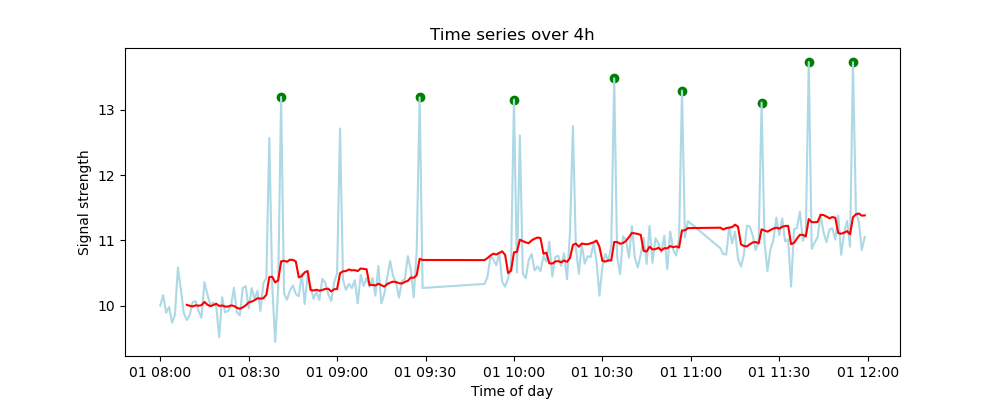

In [55]:
# YOUR CODE HERE

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(ts, color='lightblue')
ax.plot(roll_mean, color='red')
ax.scatter(ts.index[anomalies], ts[anomalies], color='green') #-> yields all anomalies, not just the true ones

ax.set(ylabel = 'Signal strength',
    xlabel = 'Time of day',
    title = 'Time series over 4h')


plt.show()

## Exercise 2: DataFrame and Series fundamentals, indexing, and missing data

Motivation: Learn to ingest data, parse dtypes, index and slice, compute derived columns, handle missing values, and make a quick plot.

Tasks:
- Read a small CSV into a DataFrame, parse dates, and set a time index.
- Compute a derived column (temperature in Fahrenheit).
- Filter by quality flag and handle missing precipitation.
- Group by station to compute daily means and plot.

In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_text = """date,station,temp_c,precip_mm,quality
2025-02-01,ST01,5.2,0.0,good
2025-02-01,ST02,3.8,,good
2025-02-02,ST01,6.0,1.2,good
2025-02-02,ST02,4.1,NaN,poor
2025-02-03,ST01,NaN,0.5,good
2025-02-03,ST02,2.9,0.0,good
2025-02-04,ST01,4.1,0.0,good
2025-02-04,ST02,2.1,0.0,good
"""

**a)** Read CSV, parse date, set index

In [ ]:
# YOUR CODE HERE

**b)** Compute temp_f = temp_c * 9/5 + 32

In [ ]:
# YOUR CODE HERE

**c)** Filter to rows with quality == 'good'

In [ ]:
# YOUR CODE HERE

**d)** Handle missing precip: fill per-station median; if all-NaN, fill 0

In [ ]:
# YOUR CODE HERE

# sanity check
assert np.isfinite(good['precip_mm']).all()

**e)** Daily mean per station (already daily), but demonstrate groupby and mean

In [ ]:
# YOUR CODE HERE

**f)** Quick plot of temp_c over time by station. You may use pandas [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) here.

In [ ]:
# YOUR CODE HERE

## Exercise 3: Interactive least-squares regression explorer

Motivation: See how polynomial degree, noise level, and sample size affect least-squares fits. Use widgets to adjust parameters and visualize fit, residuals, and summary metrics in real time.

**Note:** For this exercise you will need the `ipywidgets` and `ipympl` packages. If not installed yet, you can add them by running the follow cell

In [ ]:
!conda install -c conda-forge ipywidgets ipympl

You may have to restart jupyter lab (not just the current kernel) for the installation to take effect. You may test
the installation by running the following cell:

In [1]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np

def myplot(xmax):
    x = np.arange(0, xmax, 0.01)
    y = np.sin(2*np.pi*x)
    plt.plot(x,y)
    
interact(myplot, xmax = (np.pi/2,4*np.pi));

interactive(children=(FloatSlider(value=7.0685834705770345, description='xmax', max=12.566370614359172, min=1.…

The code below already provides the following ingredients
- Create sliders for number of points, noise standard deviation, and polynomial degree (1-6).
- Create a dropdown for x sampling scheme (uniform random vs evenly spaced) and a checkbox to show residual stems.
- Fit a polynomial using NumPy’s Vandermonde matrix and np.linalg.lstsq;

Your task:
* connect the widgets to functions such that the display is updated
* fill in the actual plotting commands

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, FloatSlider, Dropdown, Checkbox, Button, HBox, VBox, Output, Label, Layout

rng = np.random.default_rng(1)
out2 = Output(layout=Layout(border='1px solid #ccc'))

# True underlying function
def f_true(x):
    return 0.5 + 0.8*x - 0.3*x**2 + 0.05*x**3 + 0.5*np.sin(2*np.pi*x)

# Controls
# number of datapoints
n_pts = IntSlider(value=80, min=20, max=500, step=10, description='n', continuous_update=False)
# noise level
noise = FloatSlider(value=0.2, min=0.0, max=1.0, step=0.05, description='noise σ', continuous_update=False)
# degree of fitting curve
degree = IntSlider(value=3, min=1, max=6, step=1, description='deg', continuous_update=False)
# x value distribution
x_scheme = Dropdown(options=['even', 'uniform'], value='even', description='x scheme')
# show residual lines in the plot
show_resid = Checkbox(value=False, description='Show residuals')
# a button to trigger resampling
resample_btn2 = Button(description='Resample', button_style='primary')
# a text label to display metrics from the poly_fit function (rss, r2)
metrics = Label(value="")

# Data cache
current_x = None
current_y = None

def make_data(n, scheme, noise_sigma):
    """
    Generate synthetic regression data (x, y) from f_true with additive Gaussian noise.

    Parameters:
    - n: number of points to generate.
    - scheme: 'even' for evenly spaced x in [0, 1], 'uniform' for sorted uniform random x.
    - noise_sigma: standard deviation of additive Gaussian noise.

    Returns:
    - Tuple (x, y) where x and y are 1D NumPy arrays of length n.
    """
    if scheme == 'even':
        x = np.linspace(0, 1, n)
    else:
        x = rng.uniform(0, 1, size=n)
        x.sort()
    y = f_true(x) + rng.normal(0.0, noise_sigma, size=n)
    return x, y

def poly_fit(x, y, deg):
    """
    Fit a polynomial of given degree to (x, y) using least squares.

    Parameters:
    - x, y: 1D arrays of equal length.
    - deg: polynomial degree (integer >= 1). The design matrix uses powers x^0..x^deg.

    Returns:
    - coef: 1D array of length deg+1 with polynomial coefficients (constant term first).
    - y_hat: 1D array of fitted y values at each x.
    - rss: residual sum of squares.
    - r2: coefficient of determination R^2 computed against y mean.
    """
    X = np.vander(x, N=deg+1, increasing=True)
    coef, residuals, rank, svals = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ coef
    rss = np.sum((y - y_hat)**2)
    tss = np.sum((y - y.mean())**2)
    r2 = 1.0 - (rss / tss if tss > 0 else np.nan)
    return coef, y_hat, rss, r2

def redraw(_=None):
    """
    Redraw the current dataset and polynomial fit in the Output widget.

    Parameters:
    - _: optional event payload from widget observers; ignored.

    Side effects:
    - Uses cached current_x/current_y. Updates the plot and the metrics label.
    - If no cached data is available, returns without drawing.
    """
    if current_x is None:
        return
    with out2:
        out2.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7, 4))
        # YOUR CODE HERE
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Least-squares polynomial fit')
        ax.legend()
        plt.tight_layout()
        plt.show()

def resample(_=None):
    """
    Generate a new dataset based on current controls and update the plot.

    Parameters:
    - _: optional event payload from the button click; ignored.

    Side effects:
    - Updates global current_x/current_y by calling make_data with controls.
    - Triggers a redraw of the plot and metrics.
    """
    global current_x, current_y
    # YOUR CODE HERE

# Wire up: connect widgets to functions.
# YOUR CODE HERE

# Initial UI and data
controls2 = VBox([
    HBox([n_pts, noise, degree]),
    HBox([x_scheme, show_resid, resample_btn2]),
    metrics
])
display(controls2, out2)
resample()